# Write a Blog Post
## Introduction
This blog post will investigate the effects of entertainment events vs baseline on Airbnb properties using the Boston dataset.  The analysis will be interesting since I will be manipulating the dataset to uncover customer satisfaction, and number of customers by time - geographic location in the city.

Three key questions:
    1a. What is the relationship, if any, between a one-time large entertainment event (an "on-peak" event) and number of AirBNB customers in the city?
    1b. What is the relationship between distance to an Airbnb from the venue for an on-peak period?
    2a. What is the relationship, if any, between customer satisfaction during an on-peak event?
    2b. How does this vary by distance distance to venue?
    3a. What is the relationship, if any, between an on-peak event and price for an AirBNB?
    3b. How does this relationship vary by distance?




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import folium
import math
import datetime
from dateutil.parser import parse


'''
NLP tools
'''
from textblob import TextBlob
from langdetect import detect

%matplotlib inline





In [2]:
#read the csv files
#note: these files are current as of 2018-11
#source: http://insideairbnb.com/get-the-data.html
calendar_df = pd.read_csv('./calendar_2.csv')
listing_df = pd.read_csv('./listings_2.csv')
review_df = pd.read_csv('./reviews_2.csv')

In [3]:
listing_df.head()

id                        listing_url       scrape_id last_scraped  \
0  3781  https://www.airbnb.com/rooms/3781  20181117191239   2018-11-17   
1  5506  https://www.airbnb.com/rooms/5506  20181117191239   2018-11-17   
2  6695  https://www.airbnb.com/rooms/6695  20181117191239   2018-11-17   
3  6976  https://www.airbnb.com/rooms/6976  20181117191239   2018-11-17   
4  8789  https://www.airbnb.com/rooms/8789  20181117191239   2018-11-17   

                                                name  \
0                          HARBORSIDE-Walk to subway   
1     **$99 Special **   Private! Minutes to center!   
2                    $125 Special!! Home Away! Condo   
3  Mexican Folk Art Haven in Boston Residential Area   
4                Curved Glass Studio/1bd facing Park   

                                             summary  \
0  Fully separate apartment in a two apartment bu...   
1  This is a private guest room with private bath...   
2                                                NaN   
3  Come stay with me in Boston's Roslindale neigh...   
4  Bright, 1 bed with curved glass windows facing...   

                                               space  \
0  This is a totally separate apartment located o...   
1  **THE BEST Value in BOSTON!!*** PRIVATE GUEST ...   
2  ** WELCOME *** FULL PRIVATE APARTMENT In a His...   
3  This is a well-maintained, two-family house bu...   
4  Fully Furnished studio with enclosed bedroom. ...   

                                         description experiences_offered  \
0  Fully separate apartment in a two apartment bu...                none   
1  This is a private guest room with private bath...                none   
2  ** WELCOME *** FULL PRIVATE APARTMENT In a His...                none   
3  Come stay with me in Boston's Roslindale neigh...                none   
4  Bright, 1 bed with curved glass windows facing...                none   

                               neighborhood_overview        ...          \
0  Mostly quiet ( no loud music, no crowed sidewa...        ...           
1  Peacful, Architecturally interesting, historic...        ...           
2  Peaceful, Architecturally interesting, histori...        ...           
3  The LOCATION: Roslindale is a safe and diverse...        ...           
4  Beacon Hill is a historic neighborhood filled ...        ...           

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN                NaN                f   
1                f     NaN                NaN                t   
2                f     NaN                NaN                t   
3                f     NaN                NaN                f   
4                f     NaN                NaN                f   

  is_business_travel_ready          cancellation_policy  \
0                        f              super_strict_30   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f                     moderate   
4                        f  strict_14_with_grace_period   

   require_guest_profile_picture require_guest_phone_verification  \
0                              f                                f   
1                              f                                f   
2                              f                                f   
3                              t                                f   
4                              f                                f   

   calculated_host_listings_count  reviews_per_month  
0                               1               0.34  
1                               6               0.68  
2                               6               0.73  
3                               1               0.66  
4                              13               0.40  

[5 rows x 96 columns]

In [4]:
for i in listing_df:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
cal

In [5]:
### Investigate the property_type
property_types = set(listing_df['property_type'])
property_types

{'Aparthotel',
 'Apartment',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Chalet',
 'Condominium',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'Hotel',
 'House',
 'In-law',
 'Loft',
 'Other',
 'Resort',
 'Serviced apartment',
 'Tiny house',
 'Townhouse',
 'Villa'}

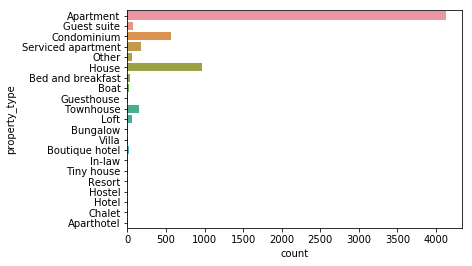

In [6]:
sns.countplot(data = listing_df, y="property_type")

### Distance to Fenway park

- Fenway park is located at 42°20′46.5″N, 71°5′51.9″W [according to Wikipedia]
- At 42° N, a degree of latitude is 111073.25426300173 m
- At 42° N, a degree of longitude is 82850.73126783255 m [according to http://www.csgnetwork.com/degreelenllavcalc.html]


In [7]:
#Converting minutes and seconds to decimal degrees, this is:
fenway_latitude = 42 + 20/60 + 46.5/3600
fenway_longitude = -1 * (71 + 5/60 + 51.9/3600)

print("Fenway is at: <" + str(fenway_latitude) + " N, " +  str(fenway_longitude) + " W>")

Fenway is at: <42.346250000000005 N, -71.09774999999999 W>


In [8]:
listing_df[['id','latitude','longitude']].head(10)

id   latitude  longitude
0  3781  42.365241 -71.029361
1  5506  42.329809 -71.095595
2  6695  42.329941 -71.093505
3  6976  42.292438 -71.135765
4  8789  42.359187 -71.062651
5  8792  42.358497 -71.062011
6  9765  42.342594 -71.079421
7  9824  42.349496 -71.085954
8  9827  42.352149 -71.063301
9  9855  42.343371 -71.098708

In [9]:
'''
distance_to_fenway

Inputs: latitude, longitude of a point on the earth's surface (in decimal degrees)
Outputs: the euclidean distance from the point to Fenway Park in Boston, 
         approximating the Earth as a plane, in meters

'''
def distance_to_fenway(lat, lon):
    lat_dist = lat - fenway_latitude
    long_dist = lon - fenway_longitude
    #convert to meters
    x_dist = lat_dist * 111073.25426300173
    y_dist = long_dist * 82850.73126783255
    #find euclidean distance
    dist = math.sqrt(x_dist**2 + y_dist**2)
    return dist   
    
    

In [10]:
distance_to_fenway(listing_df['latitude'][0], listing_df['longitude'][0])

6045.959077183828

## Explore and clean latitude and longitude coordinate data

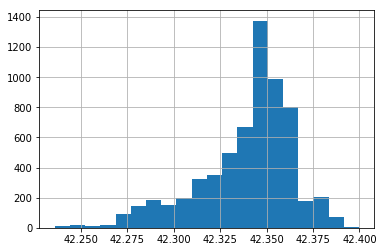

In [11]:
listing_df['latitude'].hist(bins = 20)

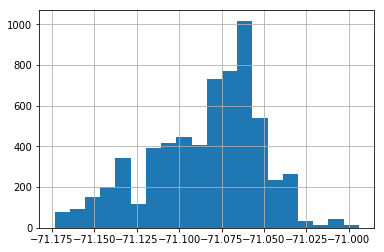

In [12]:
listing_df['longitude'].hist(bins = 20)

### Evaluate the Folium package

The Folium package allows for plotting geospatial data

# Distnace to Fenway Park

Boston's MLB Red Sox play at the famous Fenway Park.  In 2018 they hosted games 1 and 2 of the World Series.  I will be using the week of the finals to look for any effects on the AirBNB data set.

In [13]:
fenway_coordinates = (fenway_latitude, fenway_longitude)
 
demo_map = folium.Map(location=fenway_coordinates, zoom_start=12)

def plot_point(lat, lon, a_map, fill_col = "#000000"):
    '''
    API ref: http://python-visualization.github.io/folium/docs-v0.5.0/modules.html
    '''
    folium.CircleMarker(location=[lat, lon], radius=2, color = fill_col, fill_color = fill_col).add_to(a_map)

for i in listing_df.iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if distance_to_fenway(lat,lon) < 3000:
        plot_point(lat, lon, demo_map, fill_col = "#FFFF88")
display(demo_map)

In [14]:
_

In [15]:
for i in calendar_df:
    print(i)

listing_id
date
available
price


In [16]:
calendar_df.query('available == "t"').head(20)

listing_id        date available    price
0       414419  2019-11-16         t  $150.00
1        22208  2019-11-16         t  $225.00
2        22208  2019-11-15         t  $225.00
3        22208  2019-11-14         t  $225.00
4        22208  2019-11-13         t  $225.00
5        22208  2019-11-12         t  $225.00
6        22208  2019-11-11         t  $225.00
7        22208  2019-11-10         t  $225.00
8        22208  2019-11-09         t  $225.00
9        22208  2019-11-08         t  $225.00
10       22208  2019-11-07         t  $225.00
11       22208  2019-11-06         t  $225.00
12       22208  2019-11-05         t  $225.00
13       22208  2019-11-04         t  $225.00
14       22208  2019-11-03         t  $225.00
15       22208  2019-11-02         t  $225.00
16       22208  2019-11-01         t  $225.00
17       22208  2019-10-31         t  $225.00
18       22208  2019-10-30         t  $225.00
19       22208  2019-10-29         t  $225.00

In [17]:
calendar_df.shape

(2298040, 4)

In [18]:
review_df.shape

(199247, 6)

In [19]:
review_df.head(20)

listing_id         id        date  reviewer_id reviewer_name  \
0         3781   37776825  2015-07-10     36059247          Greg   
1         3781   41842494  2015-08-09     10459388           Tai   
2         3781   45282151  2015-09-01     12264652        Damien   
3         3781   49022647  2015-09-30     41426327          Mike   
4         3781   52503327  2015-10-30     15151513          Ivan   
5         3781   63371931  2016-02-22     55456499     John-Mark   
6         3781   67909504  2016-04-01     55456499     John-Mark   
7         3781   97906006  2016-08-28     88528884         Elisa   
8         3781  105143774  2016-09-30      1342806        Nicole   
9         3781  129692749  2017-02-01     55126634        Carlos   
10        3781  155725362  2017-05-28    117390053       Carolyn   
11        3781  184356065  2017-08-19     70187382        Justin   
12        3781  194026175  2017-09-15     11888800          John   
13        3781  284969158  2018-07-02    173840231         Artur   
14        5506       1021  2009-03-21         8903         Jenny   
15        5506       1953  2009-05-01        12970         Clint   
16        5506      10089  2009-09-14        14033       Nicolas   
17        5506      18678  2009-11-29        51993         Sarah   
18        5506      24467  2010-01-19        68674        LaJuan   
19        5506      25958  2010-02-13        47993   Juan Carlos   

                                             comments  
0   The apartment was as advertised and Frank was ...  
1   It was a pleasure to stay at Frank's place. Th...  
2   The apartment description is entirely faithful...  
3   Thoroughly enjoyed my time at Frank's home. Ha...  
4   Great value for the money! This location has e...  
5   Frank was very accommodating throughout my sta...  
6   Excellent! This was my second stay at the Jeff...  
7   Frank was a wonderful and accommodating host. ...  
8   Frank was great, the apartment has everything ...  
9   Very nice. Comfortable apartment. Good locatio...  
10  Apartment was everything described. Very clean...  
11  Frank's place is in a great part of East Bosto...  
12  Franks' place is the ground floor unit in a 3 ...  
13       Great place, amazing city, fantastic host!!!  
14  Terry's Hotel Alterntv in Boston was a perfect...  
15  Warm and accommodating host. Beautiful and wel...  
16  We stay 3 nights at the Hotel Alternative and ...  
17  We stayed in the private room.  Terry provided...  
18  Stayed here recently during a conference and t...  
19  My partner and I stayed for a week at Terry's ...

## Distance to TD Garden

We will also look for significant one-time events at TD Garden

Latitude: 42°21′58.69″N 

Longitude: 71°3′44.02″W

In [20]:
#Converting minutes and seconds to decimal degrees, this is:
tdg_latitude = 42 + 21/60 + 51.58/3600
tdg_longitude = -1 * (71 + 3/60 + 44.02/3600)

print("TD Gardens is at: <" + str(tdg_latitude) + " N, " +  str(tdg_longitude) + " W>")

TD Gardens is at: <42.36432777777778 N, -71.06222777777778 W>


In [21]:
'''
distance_to_tdg

Inputs: latitude, longitude of a point on the earth's surface (in decimal degrees)
Outputs: the euclidean distance from the point to TD Gardens in Boston, 
         approximating the Earth as a plane, in meters

'''
def distance_to_tdg(lat, lon):
    lat_dist = lat - tdg_latitude
    long_dist = lon - tdg_longitude
    #convert to meters
    x_dist = lat_dist * 111073.25426300173
    y_dist = long_dist * 82850.73126783255
    #find euclidean distance
    dist = math.sqrt(x_dist**2 + y_dist**2)
    return dist  

In [22]:
tdg_coordinates = (tdg_latitude, tdg_longitude)
 
demo_map2 = folium.Map(location=tdg_coordinates, zoom_start=12)
 
for i in listing_df.iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if distance_to_tdg(lat,lon) < 3000:
        plot_point(lat, lon, demo_map2, fill_col = "#0000FF")

display(demo_map2)

## The Boston Marathon

From Wikipedia:
    The event attracts 500,000 spectators each year, making it New England's most widely viewed sporting event
    The course runs through 26 miles 385 yards (42.195 km) of winding roads, following Route 135, Route 16, 
    Route 30 and city streets into the center of Boston, where the official finish line is located at 
    Copley Square, alongside the Boston Public Library.
    
From Google maps:
    Copley Square is at (42.350050, -71.076535)

In [23]:
cs_latitude = 42.350050
cs_longitude = -71.076535

'''
distance_to_cs

Inputs: latitude, longitude of a point on the earth's surface (in decimal degrees)
Outputs: the euclidean distance from the point to Copley Square in Boston, 
         approximating the Earth as a plane, in meters

'''
def distance_to_cs(lat, lon):
    lat_dist = lat - cs_latitude
    long_dist = lon - cs_longitude
    #convert to meters
    x_dist = lat_dist * 111073.25426300173
    y_dist = long_dist * 82850.73126783255
    #find euclidean distance
    dist = math.sqrt(x_dist**2 + y_dist**2)
    return dist 

In [24]:
cs_coordinates = (cs_latitude, cs_longitude)
 
demo_map3 = folium.Map(location=cs_coordinates, zoom_start=12)
 
for i in listing_df.iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if distance_to_cs(lat,lon) < 3000:
        plot_point(lat, lon, demo_map3, fill_col = "#00FF00")

display(demo_map3)

In [25]:
'''
Add the distance from each AirBNB listing to each of the entertainment venues to the dataframe
'''

listing_df['dist_fenway'] = listing_df.apply(lambda x: distance_to_fenway(x['latitude'], x['longitude']), axis = 1)
listing_df['dist_tdg'] = listing_df.apply(lambda x: distance_to_tdg(x['latitude'], x['longitude']), axis = 1)
listing_df['dist_cs'] = listing_df.apply(lambda x: distance_to_cs(x['latitude'], x['longitude']), axis = 1)

### Examining the distance Data

We will look at the distribution of these distances to see if there are any problems so far

In [26]:
listing_df[['id', 'dist_fenway', 'dist_tdg', 'dist_cs']].head(10)

id  dist_fenway      dist_tdg      dist_cs
0  3781  6045.959077   2724.885569  4257.039211
1  5506  1834.919987   4726.854938  2747.433257
2  6695  1845.360597   4615.586152  2639.286985
3  6976  6756.144660  10043.959133  8064.155805
4  8789  3243.623760    572.088468  1533.989402
5  8792  3258.491657    647.893365  1525.838683
6  9765  1571.940535   2802.927919   861.934600
7  9824  1041.713778   2564.748782   782.778551
8  9827  2928.332118   1355.703454  1120.923734
9  9855   329.514092   3814.925550  1981.227530

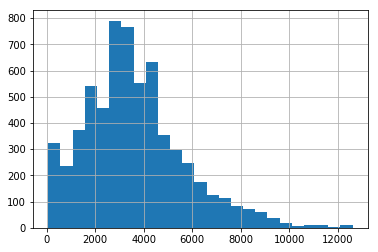

In [27]:
listing_df['dist_fenway'].hist(bins = 25)

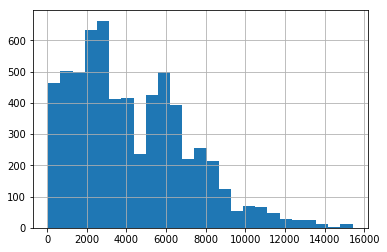

In [28]:
listing_df['dist_tdg'].hist(bins = 25)

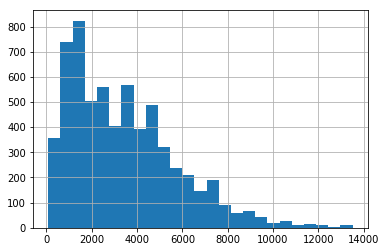

In [29]:
listing_df['dist_cs'].hist(bins = 25)

Examining these distributions, the distances are all < 15 km from the selected venues, so the data looks like it is all usable (there are no rogue AirBNBs at the equator, for example)

## Exploring Review Frequency

TD Garden dates:
 - April 9: Pink - Beautiful Trauma World Tour (att: 32,403)
 - April 10: Pink - Beautiful Trauma World Tour (att: 32,403)
 - June 21: U2 - Experience + Innocence Tour (att: 32,403
 - June 22: U2 - Experience + Innocence Tour (att: 32,403)
 
Fenway Dates:
 - October 23: World Series
 - October 24: World Series
 
Other:
 -  April 16: Boston Marathon
   
Note: I have not included MLB, NHL, or NBA regular season games, since these occur very frequently and are not "one-off" events.  I have also excluded all events at Gillette stadium, such as large ourdoor concerts and New England Patriots games, since this venue is 45km from Boston and is actually closer to Providence, RI. (per Wikipedia)
    
    


In [30]:
def parse_date(date_string):
    try:
        event_date = datetime.datetime.strptime(date_string, "%Y-%m-%d").date()
    except:
        event_date = ""
    return event_date

In [31]:
review_df['parsed_date'] = review_df.apply(lambda x: parse_date(x['date']), axis = 1)

In [32]:
review_df.head(20)

listing_id         id        date  reviewer_id reviewer_name  \
0         3781   37776825  2015-07-10     36059247          Greg   
1         3781   41842494  2015-08-09     10459388           Tai   
2         3781   45282151  2015-09-01     12264652        Damien   
3         3781   49022647  2015-09-30     41426327          Mike   
4         3781   52503327  2015-10-30     15151513          Ivan   
5         3781   63371931  2016-02-22     55456499     John-Mark   
6         3781   67909504  2016-04-01     55456499     John-Mark   
7         3781   97906006  2016-08-28     88528884         Elisa   
8         3781  105143774  2016-09-30      1342806        Nicole   
9         3781  129692749  2017-02-01     55126634        Carlos   
10        3781  155725362  2017-05-28    117390053       Carolyn   
11        3781  184356065  2017-08-19     70187382        Justin   
12        3781  194026175  2017-09-15     11888800          John   
13        3781  284969158  2018-07-02    173840231         Artur   
14        5506       1021  2009-03-21         8903         Jenny   
15        5506       1953  2009-05-01        12970         Clint   
16        5506      10089  2009-09-14        14033       Nicolas   
17        5506      18678  2009-11-29        51993         Sarah   
18        5506      24467  2010-01-19        68674        LaJuan   
19        5506      25958  2010-02-13        47993   Juan Carlos   

                                             comments parsed_date  
0   The apartment was as advertised and Frank was ...  2015-07-10  
1   It was a pleasure to stay at Frank's place. Th...  2015-08-09  
2   The apartment description is entirely faithful...  2015-09-01  
3   Thoroughly enjoyed my time at Frank's home. Ha...  2015-09-30  
4   Great value for the money! This location has e...  2015-10-30  
5   Frank was very accommodating throughout my sta...  2016-02-22  
6   Excellent! This was my second stay at the Jeff...  2016-04-01  
7   Frank was a wonderful and accommodating host. ...  2016-08-28  
8   Frank was great, the apartment has everything ...  2016-09-30  
9   Very nice. Comfortable apartment. Good locatio...  2017-02-01  
10  Apartment was everything described. Very clean...  2017-05-28  
11  Frank's place is in a great part of East Bosto...  2017-08-19  
12  Franks' place is the ground floor unit in a 3 ...  2017-09-15  
13       Great place, amazing city, fantastic host!!!  2018-07-02  
14  Terry's Hotel Alterntv in Boston was a perfect...  2009-03-21  
15  Warm and accommodating host. Beautiful and wel...  2009-05-01  
16  We stay 3 nights at the Hotel Alternative and ...  2009-09-14  
17  We stayed in the private room.  Terry provided...  2009-11-29  
18  Stayed here recently during a conference and t...  2010-01-19  
19  My partner and I stayed for a week at Terry's ...  2010-02-13

In [33]:
review_df['parsed_date'][1].year

2015

In [34]:
start_date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d").date()
reviews_2018 = review_df.query("parsed_date >=  @start_date")

In [35]:
reviews_2018.groupby('listing_id').count().sort_values(by = 'id').tail(20)

id  date  reviewer_id  reviewer_name  comments  parsed_date
listing_id                                                              
4090224     112   112          112            112       110          112
12233043    113   113          113            113       112          113
15166391    118   118          118            118       118          118
22327141    120   120          120            120       120          120
18873614    120   120          120            120       120          120
1584362     121   121          121            121       121          121
18138472    122   122          122            122       122          122
18342707    124   124          124            124       124          124
18584891    124   124          124            124       123          124
13594886    124   124          124            124       124          124
19219071    124   124          124            124       123          124
22525268    126   126          126            126       126          126
17974950    126   126          126            126       126          126
9362821     128   128          128            128       128          128
22099733    133   133          133            133       133          133
15844973    135   135          135            135       135          135
18290558    140   140          140            140       140          140
13393418    143   143          143            143       143          143
15841355    150   150          150            150       150          150
19315157    151   151          151            151       151          151

## Number of Reviews by Listing

### Reviews by Month
We need to determine a baseline rate of reviews, this should reflect seasonal variation

In [36]:
review_df['month'] = review_df.apply(lambda x: x['parsed_date'].month, axis = 1)

In [37]:
review_df.groupby('month').count()

listing_id     id   date  reviewer_id  reviewer_name  comments  \
month                                                                   
1            6369   6369   6369         6369           6369      6361   
2            6178   6178   6178         6178           6178      6174   
3           11155  11155  11155        11155          11155     11145   
4           16124  16124  16124        16124          16124     16114   
5           19956  19956  19956        19956          19956     19913   
6           19554  19554  19554        19554          19554     19507   
7           21447  21447  21447        21447          21447     21426   
8           23799  23799  23799        23799          23799     23752   
9           25490  25490  25490        25490          25490     25464   
10          29426  29426  29426        29426          29426     29413   
11          13015  13015  13015        13015          13015     13008   
12           6734   6734   6734         6734           6734      6732   

       parsed_date  
month               
1             6369  
2             6178  
3            11155  
4            16124  
5            19956  
6            19554  
7            21447  
8            23799  
9            25490  
10           29426  
11           13015  
12            6734

In [38]:
seasonal_rate = review_df.groupby('month')[['month']].count().apply(lambda x: x.tolist()).to_dict()['month']
seasonal_rate

{1: 6369,
 2: 6178,
 3: 11155,
 4: 16124,
 5: 19956,
 6: 19554,
 7: 21447,
 8: 23799,
 9: 25490,
 10: 29426,
 11: 13015,
 12: 6734}

# Exploring Language Features

This is related to processing the AirBnB reviews.

 - LangDetect, for detecting language
 - TextBlob, for Sentiment Analysis

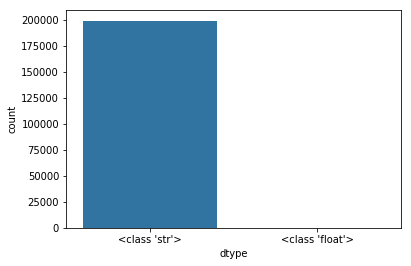

In [39]:
#explore the data - what types are there?
review_df['dtype'] = review_df['comments'].apply(lambda x: type(x))
sns.countplot(review_df['dtype'])

## Determine the language of reviews
And look for invalid or emmpty strings

In [40]:
#not all reviews ae in English.
#not all are valid (for example, some are empty)
'''
Attempts to detect the laguage of a string
If invalid, returns an empty string
'''
def try_to_detect(txt):
    ret = ''
    try:
        ret = detect(txt)
    except:
        ret = ''
    return ret


review_df['lang'] = review_df['comments'].apply(lambda x: '' if isinstance(x, float) else try_to_detect(x) )

In [41]:
review_df.groupby('lang').count()

listing_id      id    date  reviewer_id  reviewer_name  comments  \
lang                                                                      
              589     589     589          589            589       351   
af            227     227     227          227            227       227   
ar              1       1       1            1              1         1   
ca            155     155     155          155            155       155   
cs             99      99      99           99             99        99   
cy             48      48      48           48             48        48   
da             82      82      82           82             82        82   
de           1473    1473    1473         1473           1473      1473   
el             17      17      17           17             17        17   
en         186154  186154  186154       186154         186154    186154   
es           2183    2183    2183         2183           2183      2183   
et             30      30      30           30             30        30   
fi             35      35      35           35             35        35   
fr           3475    3475    3475         3475           3475      3475   
he              4       4       4            4              4         4   
hr             25      25      25           25             25        25   
hu             36      36      36           36             36        36   
id             21      21      21           21             21        21   
it            506     506     506          506            506       506   
ja            139     139     139          139            139       139   
ko            678     678     678          678            678       678   
lt              3       3       3            3              3         3   
lv              2       2       2            2              2         2   
mk              1       1       1            1              1         1   
nl            271     271     271          271            271       271   
no             73      73      73           73             73        73   
pl            100     100     100          100            100       100   
pt            468     468     468          468            468       468   
ro            553     553     553          553            553       553   
ru             91      91      91           91             91        91   
sk             14      14      14           14             14        14   
sl             13      13      13           13             13        13   
so            218     218     218          218            218       218   
sq              4       4       4            4              4         4   
sv             82      82      82           82             82        82   
sw             20      20      20           20             20        20   
th              4       4       4            4              4         4   
tl             87      87      87           87             87        87   
tr             29      29      29           29             29        29   
uk              1       1       1            1              1         1   
vi             38      38      38           38             38        38   
zh-cn        1176    1176    1176         1176           1176      1176   
zh-tw          22      22      22           22             22        22   

       parsed_date   month   dtype  
lang                                
               589     589     589  
af             227     227     227  
ar               1       1       1  
ca             155     155     155  
cs              99      99      99  
cy              48      48      48  
da              82      82      82  
de            1473    1473    1473  
el              17      17      17  
en          186154  186154  186154  
es            2183    2183    2183  
et              30      30      30  
fi              35      35      35  
fr            3475    3475    3475  
he               4       4       4  
hr

There are many non-English reviews that need to be disregarded for sentiment analysis.

## Determine distribution of review sentiment

In [42]:
review_df['sentiment'] = review_df.query('lang == "en"')['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

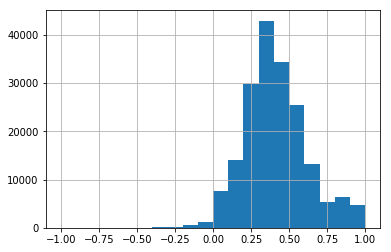

In [43]:
review_df['sentiment'].hist(bins=20)

This shows that almost all reviews are positive

# Assembling the Data

Plotting the geospatial data requires joining the listings (for coordinates) with the calendar (for the prices) and the reviews (for the sentiment analysis and number of customers).

Prices need to be broken out by property type (a house lists for more than a condo).

### 1.  How busy are the AirBNBs?

In [44]:
#Get review count by week

'''
one_week_after
in: a date to query, a target date
out: boolean representing whether the validation date was one week or less after the event date
'''
def one_week_after(query_date, event_date):
    delta = query_date - event_date
    return (delta.days < 7 and delta.days >= 0)

'''
reviews_by_week
inputs: a listing id and a date
out: the number of listings for that listing id, over a seven-day interval starting with the date
note: the seven day interval assumes that reviews are posted by users within that timeframe, also removes variability by day of the week
'''
def reviews_by_week(l_id, event_date):
    ret = 0
    for i, row in review_df.query("listing_id == @l_id").iterrows():
        if one_week_after(row['parsed_date'], event_date):
            ret = ret + 1
    return ret
    


In [45]:
ids = set(listing_df['id'])

reviews_after_ws = {}
event_date = datetime.datetime.strptime("2018-10-23", "%Y-%m-%d").date()
for i in ids:    
    reviews_after_ws[i] = reviews_by_week(i, event_date)

reviews_after_ws 

{20152320: 1,
 11927580: 0,
 18841628: 0,
 21528608: 0,
 9404451: 0,
 4358181: 0,
 1081386: 2,
 28606510: 0,
 19824694: 0,
 22151224: 0,
 1867834: 0,
 18776123: 0,
 29360188: 0,
 27525182: 2,
 18612312: 0,
 13762650: 0,
 24871006: 1,
 163941: 1,
 16285798: 0,
 1867881: 0,
 6914155: 0,
 1966195: 0,
 28639363: 0,
 21495950: 0,
 16515215: 0,
 17924239: 0,
 29360278: 0,
 19824791: 0,
 27459736: 0,
 27459741: 0,
 29491358: 0,
 17268897: 0,
 27459746: 0,
 14549157: 0,
 27459750: 0,
 12812461: 2,
 24969391: 0,
 23265459: 0,
 1638584: 2,
 14778561: 1,
 19071169: 0,
 196806: 1,
 24346826: 0,
 20775116: 2,
 11370704: 0,
 14680277: 4,
 17006819: 0,
 1868004: 0,
 20087012: 0,
 24051948: 0,
 29851903: 0,
 6881541: 1,
 4489490: 0,
 13959444: 0,
 23626006: 2,
 29491487: 2,
 22937896: 3,
 17006890: 0,
 28967211: 1,
 14483758: 0,
 13926704: 0,
 29589809: 0,
 20250936: 0,
 24248639: 2,
 16843072: 2,
 29131076: 0,
 1868124: 0,
 6291807: 0,
 12190053: 0,
 24314218: 0,
 20152689: 1,
 5734770: 2,
 26444145:

In [46]:
ws_count = sum(reviews_after_ws.values()) * 92 / 7
sep_oct_nov_count = review_df.query('month == "9" | month == "10" | month == "11"').query("parsed_date >=  @start_date").count()
anomaly_ws = ws_count / sep_oct_nov_count['id']
anomaly_ws

1.5175519855059856

There appears to be a sizeable increase in the reviews around the World Series, for all of Boston

In [47]:
reviews_after_u2 = {}
event_date = datetime.datetime.strptime("2018-06-21", "%Y-%m-%d").date()
for i in ids:    
    reviews_after_u2[i] = reviews_by_week(i, event_date)

u2_count = sum(reviews_after_u2.values()) * 92 / 7
may_jun_jul_count = review_df.query('month == 5 | month == "6" | month == "7"').query("parsed_date >=  @start_date").count()
anomaly_u2 = u2_count / may_jun_jul_count['id']
anomaly_u2

1.087254971339608

In [48]:
reviews_after_bm = {}
event_date = datetime.datetime.strptime("2018-04-16", "%Y-%m-%d").date()
for i in ids:    
    reviews_after_bm[i] = reviews_by_week(i, event_date)

bm_count = sum(reviews_after_bm.values()) * 92 / 7
#query three months in 2018
mar_apr_may_count = review_df.query('month == "3" | month == "4" | month == "5"').query("parsed_date >=  @start_date").count()
anomaly_bm = bm_count / mar_apr_may_count['id']
anomaly_bm

1.2314670698625874

In [49]:
reviews_after_pink = {}
event_date = datetime.datetime.strptime("2018-04-09", "%Y-%m-%d").date()
for i in ids:    
    reviews_after_pink[i] = reviews_by_week(i, event_date)

pink_count = sum(reviews_after_pink.values()) * 92 / 7
anomaly_pink = pink_count / mar_apr_may_count['id']
anomaly_pink

0.9135182867561575

### Question 1a:
What is the relationship between an on-peak event and occupancy rates?

#### Finding:
The effects of the World Series and Boston Marathon appear to be showing as anomalies in the number of reviews one week after the event, with 51% and 23% increases, respectively, in the number of reviews versus the three-month window of the event.
The U2 concerts had a +8% anomaly, while the Pink concerts had a -9% anomaly.  However, the Pink concert may have been distorted by the effects of the Boston Marathon, held one week later.

These preliminary fingings are sufficient to investigate Question 1b.

In [50]:
#Variation of anomaly by distance to venue
#Will check on 500m intervals
#Longest distance is 16km

pink_dist = {}
u2_dist = {}
ws_dist = {}
bm_dist = {}

'''
anomaly_by_dist(max_dist, col, ev_date_string, timeframe)
    in: 
        max_dist - the function will evaluate airbnbs between [max_dist-500, max_dist] m
        col - the dataframe column with the distance to the venue
        ev_date_string - an ISO format date string, the function will consider this date and the subsequent 6 days
        #timeframe - a three month window to obtain the seasonally-adjusted numbers eg [4,5,6] for an event in May
    out: the airbnb review rate anomaly for the week containing the event vs the timeframe window
'''
def anomaly_by_dist(max_dist, col, ev_date_string):#, timeframe):
    reviews_after_event = {}
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()
    
    #subset of ids within the specified distance
    min_dist = max_dist - 500
    
    if col == 'dist_fenway':
        dist_df = listing_df.query("dist_fenway <= @max_dist & dist_fenway > @min_dist")
    elif col == 'dist_tdg':
        dist_df = listing_df.query("dist_tdg <= @max_dist & dist_tdg > @min_dist")
    else:
        dist_df = listing_df.query("dist_cs <= @max_dist & dist_cs > @min_dist")
        
    ids = set(dist_df['id'])
    
    for i in ids:    
        reviews_after_event[i] = reviews_by_week(i, event_date)
    
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
        
    #Seasonal count of reviews within the distance range
    seasonal_count = review_df[review_df.listing_id.isin(ids)].query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date").count()
    
    #The intervals we are looking at all happen to have 92 days
    count = sum(reviews_after_event.values()) * 92 / 7
    
    if seasonal_count['id'] == 0:
        return 1
    else:
        anomaly = count / seasonal_count['id']
        return anomaly
    

    
    

In [51]:
for i in range (1, 32):
    dist = i * 500
    ws_dist[dist] = anomaly_by_dist(dist, 'dist_fenway', '2018-10-23')
    
ws_dist

{500: 1.8077535847052575,
 1000: 1.7010509926041262,
 1500: 1.4283697953422725,
 2000: 1.4105799151343705,
 2500: 1.6389362427548584,
 3000: 1.4950610727562401,
 3500: 1.5088220389736031,
 4000: 1.446264196054991,
 4500: 1.4616671067687703,
 5000: 1.6249897783956169,
 5500: 1.4983412084045442,
 6000: 1.5998239049086507,
 6500: 1.663168831168831,
 7000: 1.413901501921062,
 7500: 1.3657487091222031,
 8000: 1.4929006085192698,
 8500: 1.3038548752834467,
 9000: 1.3253301320528212,
 9500: 1.8705189941144997,
 10000: 1.449579831932773,
 10500: 1.9233449477351918,
 11000: 1.688073394495413,
 11500: 1.9391100702576114,
 12000: 0.0,
 12500: 0.9387755102040816,
 13000: 0.0,
 13500: 1,
 14000: 1,
 14500: 1,
 15000: 1,
 15500: 1}

In [52]:
'''
pink_dist = {}
u2_dist = {}
ws_dist = {}
bm_dist = {}
'''

for i in range (1, 32):
    dist = i * 500
    pink_dist[dist] = anomaly_by_dist(dist, 'dist_tdc', '2018-04-09')
    
pink_dist

{500: 0.6906278434940856,
 1000: 0.8590484659848822,
 1500: 0.9401863540727382,
 2000: 0.978626105974749,
 2500: 0.9442712689120353,
 3000: 0.9885119610758211,
 3500: 1.0166422580215684,
 4000: 0.8476322567862096,
 4500: 0.977140043609763,
 5000: 0.9139340659340659,
 5500: 0.8651638777485825,
 6000: 0.842720717209121,
 6500: 0.8304552590266876,
 7000: 0.9387755102040816,
 7500: 0.7865416436845009,
 8000: 0.610204081632653,
 8500: 0.9387755102040816,
 9000: 1.1330049261083743,
 9500: 1.1572327044025157,
 10000: 0.23057644110275688,
 10500: 0.773109243697479,
 11000: 0.847926267281106,
 11500: 0.8761904761904762,
 12000: 1.4603174603174605,
 12500: 0.0,
 13000: 0.0,
 13500: 0.0,
 14000: 1,
 14500: 1,
 15000: 1,
 15500: 1}

In [53]:
for i in range (1, 32):
    dist = i * 500
    u2_dist[dist] = anomaly_by_dist(dist, 'dist_tdc', '2018-06-22')
    
u2_dist

{500: 1.1234735413839891,
 1000: 1.075456795324101,
 1500: 1.160054917262808,
 2000: 1.0477306983754815,
 2500: 1.2020531964535697,
 3000: 1.1458124439284396,
 3500: 1.0102417907295955,
 4000: 0.9695550351288056,
 4500: 1.1477411477411477,
 5000: 1.135650897444452,
 5500: 1.0441994979810105,
 6000: 1.0983944009880608,
 6500: 1.1501753316054277,
 7000: 1.326723749436683,
 7500: 1.0293706293706293,
 8000: 0.9558441558441558,
 8500: 0.8940719144800776,
 9000: 1.1452282157676348,
 9500: 1.0257839721254356,
 10000: 0.9981916817359856,
 10500: 1.5515873015873014,
 11000: 1.3529411764705883,
 11500: 1.0952380952380953,
 12000: 1.314285714285714,
 12500: 0.48677248677248675,
 13000: 2.6285714285714286,
 13500: 1.010989010989011,
 14000: 1,
 14500: 1,
 15000: 1,
 15500: 1}

In [54]:
for i in range (1, 32):
    dist = i * 500
    bm_dist[dist] = anomaly_by_dist(dist, 'dist_cs', '2018-04-16')
    
bm_dist

{500: 1.548680618744313,
 1000: 1.2739630311884649,
 1500: 1.2364635664906178,
 2000: 1.070086489710707,
 2500: 1.0911579107427962,
 3000: 1.131504257332072,
 3500: 1.3351085075223008,
 4000: 1.230433921141272,
 4500: 1.2489273405078427,
 5000: 1.2778901098901099,
 5500: 1.2214078274097635,
 6000: 1.2192555057493666,
 6500: 1.3720565149136579,
 7000: 1.4668367346938775,
 7500: 1.1671263099834528,
 8000: 1.126530612244898,
 8500: 1.4668367346938775,
 9000: 1.284072249589491,
 9500: 1.5705300988319857,
 10000: 0.6917293233082707,
 10500: 0.9019607843137255,
 11000: 1.271889400921659,
 11500: 1.168253968253968,
 12000: 1.2169312169312168,
 12500: 1.7142857142857144,
 13000: 0.0,
 13500: 0.0,
 14000: 1,
 14500: 1,
 15000: 1,
 15500: 1}

In [210]:
dist_anom_df = pd.DataFrame()
dist_anom_df['distance'] = bm_dist.keys()
dist_anom_df['Marathon'] = bm_dist.values()
dist_anom_df['World_Ser'] = ws_dist.values()
dist_anom_df['Pink'] = pink_dist.values()
dist_anom_df['U2'] = u2_dist.values()

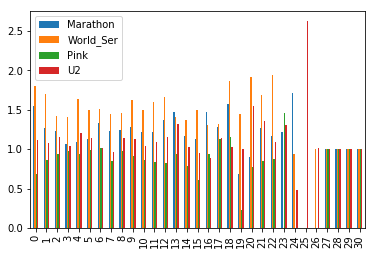

In [220]:
dist_anom_df.plot.bar(y = ['Marathon', 'World_Ser', 'Pink', 'U2'])

/home/ian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


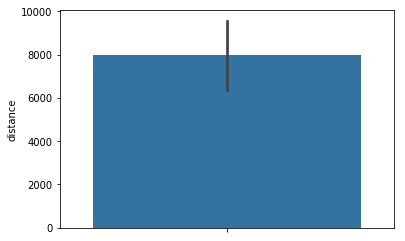

In [55]:
review_df.head(20)

listing_id         id        date  reviewer_id reviewer_name  \
0         3781   37776825  2015-07-10     36059247          Greg   
1         3781   41842494  2015-08-09     10459388           Tai   
2         3781   45282151  2015-09-01     12264652        Damien   
3         3781   49022647  2015-09-30     41426327          Mike   
4         3781   52503327  2015-10-30     15151513          Ivan   
5         3781   63371931  2016-02-22     55456499     John-Mark   
6         3781   67909504  2016-04-01     55456499     John-Mark   
7         3781   97906006  2016-08-28     88528884         Elisa   
8         3781  105143774  2016-09-30      1342806        Nicole   
9         3781  129692749  2017-02-01     55126634        Carlos   
10        3781  155725362  2017-05-28    117390053       Carolyn   
11        3781  184356065  2017-08-19     70187382        Justin   
12        3781  194026175  2017-09-15     11888800          John   
13        3781  284969158  2018-07-02    173840231         Artur   
14        5506       1021  2009-03-21         8903         Jenny   
15        5506       1953  2009-05-01        12970         Clint   
16        5506      10089  2009-09-14        14033       Nicolas   
17        5506      18678  2009-11-29        51993         Sarah   
18        5506      24467  2010-01-19        68674        LaJuan   
19        5506      25958  2010-02-13        47993   Juan Carlos   

                                             comments parsed_date  month  \
0   The apartment was as advertised and Frank was ...  2015-07-10      7   
1   It was a pleasure to stay at Frank's place. Th...  2015-08-09      8   
2   The apartment description is entirely faithful...  2015-09-01      9   
3   Thoroughly enjoyed my time at Frank's home. Ha...  2015-09-30      9   
4   Great value for the money! This location has e...  2015-10-30     10   
5   Frank was very accommodating throughout my sta...  2016-02-22      2   
6   Excellent! This was my second stay at the Jeff...  2016-04-01      4   
7   Frank was a wonderful and accommodating host. ...  2016-08-28      8   
8   Frank was great, the apartment has everything ...  2016-09-30      9   
9   Very nice. Comfortable apartment. Good locatio...  2017-02-01      2   
10  Apartment was everything described. Very clean...  2017-05-28      5   
11  Frank's place is in a great part of East Bosto...  2017-08-19      8   
12  Franks' place is the ground floor unit in a 3 ...  2017-09-15      9   
13       Great place, amazing city, fantastic host!!!  2018-07-02      7   
14  Terry's Hotel Alterntv in Boston was a perfect...  2009-03-21      3   
15  Warm and accommodating host. Beautiful and wel...  2009-05-01      5   
16  We stay 3 nights at the Hotel Alternative and ...  2009-09-14      9   
17  We stayed in the private room.  Terry provided...  2009-11-29     11   
18  Stayed here recently during a conference and t...  2010-01-19      1   
19  My partner and I stayed for a week at Terry's ...  2010-02-13      2   

            dtype lang  sentiment  
0   <class 'str'>   en   0.300000  
1   <class 'str'>   en  -0.150000  
2   <class 'str'>   en   0.134375  
3   <class 'str'>   en   0.387667  
4   <class 'str'>   en   0.225000  
5   <class 'str'>   en   0.281944  
6   <class 'str'>   en   0.266667  
7   <class 'str'>   en   0.433500  
8   <class 'str'>   en   0.790625  
9   <class 'str'>   en   0.665000  
10  <class 'str'>   en   0.350556  
11  <class 'str'>   en   0.297917  
12  <class 'str'>   en   0.312433  
13  <class 'str'>   en   0.727083  
14  <class 'str'>   en   0.750000  
15  <class 'str'>   en   0.725000  
16  <class 'str'>   en   0.606000  
17  <class 'str'>   en   0.120000  
18  <class 'str'>   en   0.316389  
19  <class 'str'>   en   0.448148

### Question 2a: Does customer sentiment vary by distance?

In [56]:
## Customer sentiment by proximity to entertainment events
'''
sentiment_by_week
inputs: a listing id and a date
out: the number of listings for that listing id, over a seven-day interval starting with the date
note: the seven day interval assumes that reviews are posted by users within that timeframe, also removes variability by day of the week
note: this function handles invalid scores
'''
def sentiment_by_week(l_id, event_date):
    ret = 0
    review_scores = []
    for i, row in review_df.query("listing_id == @l_id").iterrows():
        if one_week_after(row['parsed_date'], event_date):
            if row['sentiment'] != np.NaN:
                review_scores.append(row['sentiment'])
            
    ret = sum(review_scores) / len(review_scores)
    return ret   


'''
sentiment_anomaly(id, col, ev_date_string, max_dist)
    in: 
        max_dist - the function will evaluate airbnbs between [max_dist-500, max_dist] m
        col - the dataframe column with the distance to the venue
        ev_date_string - an ISO format date string, the function will consider this date and the subsequent 6 days
        #timeframe - a three month window to obtain the seasonally-adjusted numbers eg [4,5,6] for an event in May
    out: the airbnb review rate anomaly for the week containing the event vs the timeframe window
'''
def sentiment_anomaly_by_dist(ev_date_string, col, max_dist):
    reviews_after_event = {}
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()
    
    #subset of ids within the specified distance
    min_dist = max_dist - 500
    
    if col == 'dist_fenway':
        dist_df = listing_df.query("dist_fenway <= @max_dist & dist_fenway > @min_dist")
    elif col == 'dist_tdg':
        dist_df = listing_df.query("dist_tdg <= @max_dist & dist_tdg > @min_dist")
    else:
        dist_df = listing_df.query("dist_cs <= @max_dist & dist_cs > @min_dist")
    
    ids = set(dist_df['id'])
    
    #mean review score for dist_df over the week after the event
    end_date = event_date + datetime.timedelta(days=6)
    one_week = (review_df['parsed_date'] > event_date) & (review_df['parsed_date'] <= end_date)
    rev_week_df = review_df[one_week]
    #impute missing values with mean - we are trying to find the mean anyway
    rev_week_df['sentiment'].fillna((rev_week_df['sentiment'].mean()), inplace=True)
    week_average = rev_week_df['sentiment'].mean()
    
    
    #for i in ids:    
    #    sentiment_after_event[i] = sentiment_by_week(i, event_date)

    #avg_sentiment_after_event = sentiment_after_event.mean()
        
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
        
    #Seasonal average of reviews within the distance range
    seasonal_sentiment = review_df[review_df.listing_id.isin(ids)].query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date")

    #impute with mean
    seasonal_sentiment['sentiment'].fillna((seasonal_sentiment['sentiment'].mean()), inplace=True)
        
    #find the mean
    seasonal_average = seasonal_sentiment['sentiment'].mean()
  
    if seasonal_sentiment.shape[1] == 0:
        return 1
    else:
        anomaly = week_average / seasonal_average
        return anomaly
    
    
'''
sentiment_anomaly2(id, ev_date_string)
    Same as sentiment anomaly, but for all AirBnBs
'''
def sentiment_anomaly_by_dist2(ev_date_string):
    reviews_after_event = {}
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()

    dist_df = listing_df
    
    ids = set(dist_df['id'])
    
    #mean review score for dist_df over the week after the event
    end_date = event_date + datetime.timedelta(days=6)
    one_week = (review_df['parsed_date'] > event_date) & (review_df['parsed_date'] <= end_date)
    rev_week_df = review_df[one_week]
    #impute missing values with mean - we are trying to find the mean anyway
    rev_week_df['sentiment'].fillna((rev_week_df['sentiment'].mean()), inplace=True)
    week_average = rev_week_df['sentiment'].mean()
    
    
    #for i in ids:    
    #    sentiment_after_event[i] = sentiment_by_week(i, event_date)

    #avg_sentiment_after_event = sentiment_after_event.mean()
        
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
        
    #Seasonal average of reviews within the distance range
    seasonal_sentiment = review_df[review_df.listing_id.isin(ids)].query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date")

    #impute with mean
    seasonal_sentiment['sentiment'].fillna((seasonal_sentiment['sentiment'].mean()), inplace=True)
        
    #find the mean
    seasonal_average = seasonal_sentiment['sentiment'].mean()
  
    if seasonal_sentiment.shape[1] == 0:
        return 1
    else:
        anomaly = week_average / seasonal_average
        return anomaly



In [57]:
u2_sent = {}

for i in range (1, 32):
    dist = i * 500
    u2_sent[dist] = sentiment_anomaly_by_dist("2018-06-21", "dist_tdg", dist)
    
u2_sent


/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


{500: 0.9412787862107947,
 1000: 0.990756027430729,
 1500: 0.9994383388974792,
 2000: 1.0029686296905393,
 2500: 1.0045704428767073,
 3000: 1.0070672891339734,
 3500: 0.9965925461258476,
 4000: 0.9954739076347449,
 4500: 0.9974259399879543,
 5000: 0.9989031582159534,
 5500: 1.0616535000680323,
 6000: 1.029816090832213,
 6500: 1.0096755896383687,
 7000: 1.0034048251834518,
 7500: 1.0478516386992938,
 8000: 0.9915549695584324,
 8500: 0.9943677221965196,
 9000: 1.049768986385853,
 9500: 1.070451225130323,
 10000: 0.9890780666321265,
 10500: 1.0272885100966058,
 11000: 0.9831777296904955,
 11500: 1.165164577817022,
 12000: 0.9919551514653883,
 12500: 1.0154514779655626,
 13000: 0.9102287355969928,
 13500: 0.9648601493456382,
 14000: 1.0292072963348415,
 14500: 0.9338908531176013,
 15000: 1.1426432241474385,
 15500: 0.995165166637784}

In [58]:
pink_sent = {}

for i in range (1, 32):
    dist = i * 500
    pink_sent[dist] = sentiment_anomaly_by_dist("2018-04-09", "dist_tdg", dist)
    
pink_sent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


{500: 0.9652844728642679,
 1000: 0.9703654778435424,
 1500: 0.9905878528531048,
 2000: 0.9971789538936702,
 2500: 0.98983692315797,
 3000: 0.9975961800463125,
 3500: 0.9971926569607643,
 4000: 0.9623991173518779,
 4500: 1.0099989098071065,
 5000: 1.008432908896223,
 5500: 1.041803791633492,
 6000: 1.0356412780957875,
 6500: 1.0021996337879018,
 7000: 1.015446705750828,
 7500: 1.0151003971026633,
 8000: 1.0004434287416553,
 8500: 0.990652643642804,
 9000: 0.9932026564684794,
 9500: 1.0039572802131156,
 10000: 0.9508829878981568,
 10500: 1.037841883219691,
 11000: 0.9508245994586865,
 11500: 1.0348457751020936,
 12000: 0.9352949858707338,
 12500: 1.0751064283507055,
 13000: 0.9087203846657479,
 13500: 1.1107682790813027,
 14000: 0.9787943047185055,
 14500: 0.6796137409665781,
 15000: 1.0663567785360082,
 15500: 0.7661345978214839}

In [59]:
ws_sent = {}

for i in range (1, 32):
    dist = i * 500
    ws_sent[dist] = sentiment_anomaly_by_dist("2018-10-23", "dist_fenway", dist)
    
ws_sent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


{500: 0.9886518048807136,
 1000: 1.0214016449144403,
 1500: 0.9795698158466342,
 2000: 0.9956478383339031,
 2500: 0.9664257070440437,
 3000: 1.0071007142459625,
 3500: 1.0176922721214505,
 4000: 0.9805704778426072,
 4500: 0.9892832857163201,
 5000: 0.9996529479925179,
 5500: 1.0374014995810603,
 6000: 1.0341754402473637,
 6500: 1.0104346537910682,
 7000: 1.0387184620732957,
 7500: 1.0304607864000497,
 8000: 1.0476731625505815,
 8500: 1.0149084944771054,
 9000: 1.0593124610699352,
 9500: 0.9986949207306439,
 10000: 0.9324001520555998,
 10500: 1.2022747300004824,
 11000: 1.0211199626274223,
 11500: 0.9803064282547911,
 12000: 1.1012721398634167,
 12500: 1.0476983410600966,
 13000: 1.085009967934234,
 13500: nan,
 14000: nan,
 14500: nan,
 15000: nan,
 15500: nan}

In [60]:
bm_sent = {}

for i in range (1, 32):
    dist = i * 500
    bm_sent[dist] = sentiment_anomaly_by_dist("2018-04-16", "dist_cs", dist)
    
bm_sent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


{500: 0.9380069770887737,
 1000: 0.9746084723565445,
 1500: 0.9947560315778411,
 2000: 0.9475978029246293,
 2500: 0.9745332731734624,
 3000: 0.9913076617588769,
 3500: 0.9900045724139038,
 4000: 1.0498454775826578,
 4500: 1.0083504161479397,
 5000: 1.0313130354000792,
 5500: 1.0062807672028053,
 6000: 1.0199096010842708,
 6500: 0.9953383952375391,
 7000: 1.0285371749972556,
 7500: 1.0025409631752327,
 8000: 1.0004739455425613,
 8500: 0.9822876763924824,
 9000: 1.0114713015525092,
 9500: 1.006086251344468,
 10000: 0.9350981578845617,
 10500: 1.1158824081505438,
 11000: 0.9045652457606628,
 11500: 1.0931910569777838,
 12000: 1.0191008905055483,
 12500: 0.9187398806979814,
 13000: 0.9999029342133192,
 13500: 0.8157911210326187,
 14000: nan,
 14500: nan,
 15000: nan,
 15500: nan}

In [61]:
pinkTotSent = sentiment_anomaly_by_dist2("2018-04-09")
pinkTotSent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0.994833690579425

In [62]:
bmTotSent = sentiment_anomaly_by_dist2("2018-04-16")
bmTotSent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0.9946243329811796

In [63]:
wsTotSent = sentiment_anomaly_by_dist2("2018-10-23")
wsTotSent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1.0041226263579717

In [64]:
u2TotSent = sentiment_anomaly_by_dist2("2018-06-21")
u2TotSent

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1.0046863773546542

Finding:  Overall, customers were neither more nor less happy with their AirBNB diring the timeframe of a major event.  However, those customers that were within ~5 km were noticeably less happy!

In [65]:
#need to use the older data!  Naughty naughty airbnb.
calendar_df = pd.read_csv('./calendar4.csv')

In [66]:
#Data cleaning: parse a float from the price string

def try_to_parse_dollars(price_):
    try:
        ret = float(price_[1:])
    except:
        ret = np.NaN
    return ret

calendar_df['price_parsed'] = calendar_df['price'].apply(try_to_parse_dollars)
calendar_df['parsed_date'] = calendar_df['date'].apply(parse_date)
calendar_df['month'] = calendar_df.apply(lambda x: x['parsed_date'].month, axis = 1)
calendar_df.head(10)

listing_id        date available   price  price_parsed parsed_date  month
0     6513924  2019-01-19         t  $55.00          55.0  2019-01-19      1
1     6513924  2019-01-18         t  $55.00          55.0  2019-01-18      1
2     6513924  2019-01-17         t  $55.00          55.0  2019-01-17      1
3     6513924  2019-01-16         t  $55.00          55.0  2019-01-16      1
4     6513924  2019-01-15         t  $55.00          55.0  2019-01-15      1
5     6513924  2019-01-14         t  $55.00          55.0  2019-01-14      1
6     6513924  2019-01-13         t  $55.00          55.0  2019-01-13      1
7     6513924  2019-01-12         t  $55.00          55.0  2019-01-12      1
8     6513924  2019-01-11         t  $55.00          55.0  2019-01-11      1
9     6513924  2019-01-10         t  $55.00          55.0  2019-01-10      1

In [67]:
## Ask price by proximity to entertainment events

## Price anomaly by proximity to entertainment events
'''
price_by_week
inputs: a listing id and a date
out: the number of listings for that listing id, over a seven-day interval starting with the date
note: the seven day interval assumes that reviews are posted by users within that timeframe, also removes variability by day of the week
note: this function handles invalid scores
'''
def prices_by_week(l_id, event_date):
    ret = 0
    prices = []
    for i, row in calendar_df.query("listing_id == @l_id").query("available = 't'").iterrows():
        if one_week_after(row['parsed_date'], event_date):
            if row['price_parsed'] != np.NaN:
                prices.append(row['price_parsed'])
            
    ret = sum(prices) / len(prices)
    return ret   


'''
price_anomaly(id, col, ev_date_string, max_dist)
    in: 
        max_dist - the function will evaluate airbnbs between [max_dist-500, max_dist] m
        col - the dataframe column with the distance to the venue
        ev_date_string - an ISO format date string, the function will consider this date and the subsequent 6 days
        #timeframe - a three month window to obtain the seasonally-adjusted numbers eg [4,5,6] for an event in May
    out: the airbnb review rate anomaly for the week containing the event vs the timeframe window
'''
def price_anomaly_by_dist(ev_date_string, col, max_dist):
    prices_after_event = {}
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()
    
    #subset of ids within the specified distance
    min_dist = max_dist - 500
    
    if col == 'dist_fenway':
        dist_df = listing_df.query("dist_fenway <= @max_dist & dist_fenway > @min_dist")
    elif col == 'dist_tdg':
        dist_df = listing_df.query("dist_tdg <= @max_dist & dist_tdg > @min_dist")
    else:
        dist_df = listing_df.query("dist_cs <= @max_dist & dist_cs > @min_dist")
    
    ids = set(dist_df['id'])
    
    #mean review score for dist_df over the week after the event
    end_date = event_date + datetime.timedelta(days=6)
    one_week = (calendar_df['parsed_date'] > event_date) & (calendar_df['parsed_date'] <= end_date)
    cal_week_df = calendar_df.query("available == 't'")[one_week] #cal_week_df
        
    #impute missing values with mean - we are trying to find the mean anyway
    cal_week_df['price_parsed'].fillna((cal_week_df['price_parsed'].mean()), inplace=True)
    week_average = cal_week_df.query('price_parsed == price_parsed')['price_parsed'].mean()
      
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
        
    #Seasonal average of reviews within the distance range
    seasonal_price = calendar_df[calendar_df.listing_id.isin(ids)].query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date").query("available == 't'")

    #impute with mean
    seasonal_price['price_parsed'].fillna((seasonal_price['price_parsed'].mean()), inplace=True)
        
    #find the mean
    seasonal_average = seasonal_price.query('price_parsed == price_parsed')['price_parsed'].mean()
  
    if seasonal_price.shape[1] == 0:
        return 1
    else:
        anomaly = week_average / seasonal_average
        return anomaly
    
    
'''
price_anomaly2(id, ev_date_string)
    Same as price anomaly, but for all AirBnBs
'''
def price_anomaly_by_dist2(ev_date_string):
    prices_after_event = {}
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()

    dist_df = listing_df
    
    ids = set(dist_df['id'])
    
    #mean review score for dist_df over the week after the event
    end_date = event_date + datetime.timedelta(days=6)
    one_week = (calendar_df['parsed_date'] > event_date) & (calendar_df['parsed_date'] <= end_date)
    cal_week_df = calendar_df.query("available == 't'")[one_week]
    #impute missing values with mean - we are trying to find the mean anyway
    cal_week_df['price_parsed'].fillna((cal_week_df['price_parsed'].mean()), inplace=True)
    week_average = cal_week_df.query('price_parsed == price_parsed')['price_parsed'].mean()
     
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
        
    #Seasonal average of reviews within the distance range
    seasonal_prices = calendar_df[calendar_df.listing_id.isin(ids)].query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date").query("available == 't'")

    #impute with mean
    seasonal_prices['price_parsed'].fillna((seasonal_prices['price_parsed'].mean()), inplace=True)
        
    #find the mean
    seasonal_average = seasonal_prices.query('price_parsed == price_parsed')['price_parsed'].mean()
  
    if seasonal_prices.shape[1] == 0:
        return 1
    else:
        anomaly = week_average / seasonal_average
        return anomaly



In [68]:
bm_price = {}

for i in range (1, 32):
    dist = i * 500
    bm_price[dist] = price_anomaly_by_dist("2018-04-16", "dist_cs", dist)
    
bm_price

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{500: 0.7893580530708398,
 1000: 0.8301674974287531,
 1500: 0.7385540860926582,
 2000: 0.7186842770740004,
 2500: 0.6344261404153515,
 3000: 0.944456337703154,
 3500: 1.028106052805526,
 4000: 0.7178675752518178,
 4500: 1.367903863043156,
 5000: 1.4222149681576628,
 5500: 1.7484229292661893,
 6000: 1.682916863670777,
 6500: 1.6418289837913316,
 7000: 1.569834657633342,
 7500: 2.0325921703308234,
 8000: 2.444019939333152,
 8500: 2.8523443843712015,
 9000: 1.862091116579955,
 9500: 2.774031889061454,
 10000: 1.5208028310588213,
 10500: 2.113951179284065,
 11000: 2.6185630994081355,
 11500: 2.498329503124969,
 12000: 1.8081476117113124,
 12500: 3.93481759798978,
 13000: 2.9794438851978615,
 13500: 3.8076939675417187,
 14000: 4.754431731698715,
 14500: nan,
 15000: nan,
 15500: nan}

In [69]:
pink_price = {}

for i in range (1, 32):
    dist = i * 500
    pink_price[dist] = price_anomaly_by_dist("2018-04-08", "dist_tdg", dist)
    
pink_price

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{500: 0.7216592168965451,
 1000: 0.8729129767609389,
 1500: 0.7030045619728653,
 2000: 0.8748166353339146,
 2500: 0.9638455345480359,
 3000: 0.954437128340663,
 3500: 0.9241566498360347,
 4000: 0.6388626736540567,
 4500: 0.9837913986294813,
 5000: 1.2013044717779353,
 5500: 1.2131015933629883,
 6000: 0.9426446904962344,
 6500: 1.657009778388963,
 7000: 1.886381286911853,
 7500: 1.6987496746531452,
 8000: 1.6294093348635619,
 8500: 1.6305933481812178,
 9000: 2.3515858601306086,
 9500: 2.3801078104524254,
 10000: 2.846341510158508,
 10500: 2.3995804777891836,
 11000: 2.3239176238232964,
 11500: 2.635968285641942,
 12000: 1.706253410324213,
 12500: 2.3180462161866164,
 13000: 2.8279215815408496,
 13500: 2.230195043372382,
 14000: 3.6696592734453124,
 14500: 2.5226544622425626,
 15000: 4.449514764801899,
 15500: 3.9264502916165793}

In [70]:
u2_price = {}

for i in range (1, 32):
    dist = i * 500
    u2_price[dist] = price_anomaly_by_dist("2018-06-21", "dist_tdg", dist)
    
u2_price

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{500: 0.7064354146999492,
 1000: 0.7951641248647227,
 1500: 0.6774496307089664,
 2000: 0.9056680474941888,
 2500: 0.9285480484769021,
 3000: 0.934204795011054,
 3500: 0.950300103615746,
 4000: 0.5891761473510709,
 4500: 0.8798785492478332,
 5000: 1.3726618941776185,
 5500: 1.1675487674512002,
 6000: 0.7522109703108335,
 6500: 1.6126627542191867,
 7000: 1.8372647101118866,
 7500: 1.8530672525476009,
 8000: 1.9036800772654903,
 8500: 1.3295888834507286,
 9000: 2.355695568103377,
 9500: 2.5188975535134803,
 10000: 3.0477737781877203,
 10500: 2.783109357191675,
 11000: 2.765969666903319,
 11500: 2.9719300213841624,
 12000: 2.2056799923134256,
 12500: 2.2597583921722713,
 13000: 2.3304809477250594,
 13500: 2.469230000155967,
 14000: 4.149962703985237,
 14500: 2.7217086447594236,
 15000: 6.060552805071255,
 15500: 4.371186783463521}

In [71]:
ws_price = {}

for i in range (1, 32):
    dist = i * 500
    ws_price[dist] = price_anomaly_by_dist("2018-10-23", "dist_fenway", dist)
    
ws_price

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{500: 0.5601153826561234,
 1000: 0.9933246980815905,
 1500: 0.8194794378284188,
 2000: 0.8892240646295092,
 2500: 0.7718982091717106,
 3000: 0.904995348189228,
 3500: 0.8291638161347211,
 4000: 0.9503273066003585,
 4500: 0.9054703932086513,
 5000: 1.11242071270122,
 5500: 1.55998533880092,
 6000: 1.4643484051231987,
 6500: 1.694657692655449,
 7000: 2.094118134803368,
 7500: 2.4294469671614953,
 8000: 1.8313512479455407,
 8500: 2.587746094718364,
 9000: 1.8676010359985304,
 9500: 1.6508569401068938,
 10000: 2.4759527512738764,
 10500: 1.6346248809197257,
 11000: 2.3804870051184204,
 11500: 2.9161573798379123,
 12000: 3.0748383760020657,
 12500: 4.475914327563473,
 13000: 3.3791192569606032,
 13500: nan,
 14000: nan,
 14500: nan,
 15000: nan,
 15500: nan}

In [72]:
price_anomaly_by_dist2("2018-10-23")

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.9994295247139292

In [73]:
price_anomaly_by_dist2("2018-06-21")

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.9225587951550293

In [74]:
price_anomaly_by_dist2("2018-04-08")

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0056960704249873

In [75]:
price_anomaly_by_dist2("2018-04-16")

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.9377387314507983

## Plotting the Price Anomaly

Plots the geospatial data where prices have increased or decreased during an event.  Seasonally adjusted.  
Two data sets -- one for houses, the other for condos/apartments (expect a significant difference between these types).

In [164]:
'''
find_price_anomaly(ev_date_string, houses)
generates plot data of airbnb sites with price over the week vs seasonal average
ev_date_string = date of event
houses = boolean: True = houses, False = condos and apartments
'''

def find_price_anomaly(ev_date_string, houses):
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()
    end_date = event_date + datetime.timedelta(days=6)
    
    if houses:
        cal_df = calendar_df.set_index('listing_id').join(listing_df.set_index('id'), lsuffix='_price', rsuffix = '_list').query("property_type == 'House'")
    else:
        cal_df = calendar_df.set_index('listing_id').join(listing_df.set_index('id'), lsuffix='_price', rsuffix = '_list').query("property_type == 'Apartment' | property_type == 'Condominium'")         
   
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
    
    start_date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d").date()
    
    one_week = (cal_df['parsed_date'] > event_date) & (cal_df['parsed_date'] <= end_date)
    prices_df = cal_df[one_week]
    seasonal_prices = cal_df.query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date").query("available == 't'")
    seasonal_prices['price_parsed'].fillna((seasonal_prices['price_parsed'].mean()), inplace=True)
    seasonal_avg = seasonal_prices.query('price_parsed == price_parsed')['price_parsed'].mean()
    prices_df['anomaly'] = prices_df['price_parsed'] / seasonal_avg
        
    return prices_df
    
    
    

In [167]:
ws_pa_cond = find_price_anomaly("2018-10-23", False)
ws_pa_house = find_price_anomaly("2018-10-23", True)

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [190]:
ws_pa_house.shape

(3840, 105)

In [194]:
ws_pa_house['anomaly'].mean()

1.0366860644922222

In [195]:
ws_pa_cond['anomaly'].mean()

1.0342733126580024

In [191]:
ws_pa_cond.shape

(20088, 105)

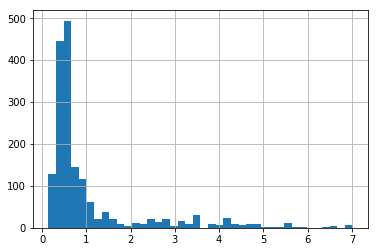

In [181]:
ws_pa_house['anomaly'].hist(bins = 40)

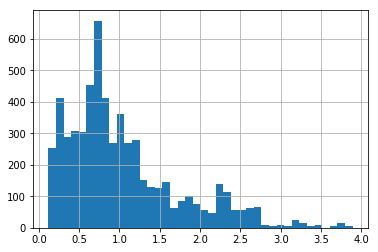

In [182]:
ws_pa_cond['anomaly'].hist(bins = 40)

In [192]:
house_map = folium.Map(location=cs_coordinates, zoom_start=11)

for i in ws_pa_house.query('latitude == latitude').sample(frac=0.75).iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if i[1]['anomaly'] < 0.5:
        plot_point(lat, lon, house_map, fill_col = "#FF0000")
    elif i[1]['anomaly'] < 1.0:
        plot_point(lat, lon, house_map, fill_col = "#FF7722")
    elif i[1]['anomaly'] < 1.5:
        plot_point(lat, lon, house_map, fill_col = "#2277FF")
    else:
        plot_point(lat, lon, house_map, fill_col = "#0000FF")
        

display(house_map)

In [193]:
plot_map = folium.Map(location=cs_coordinates, zoom_start=11)

   
for i in ws_pa_cond.query('latitude == latitude').sample(frac=0.18).iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if i[1]['anomaly'] < 0.5:
        plot_point(lat, lon, plot_map, fill_col = "#FF0000")
    elif i[1]['anomaly'] < 1.0:
        plot_point(lat, lon, plot_map, fill_col = "#FF7722")
    elif i[1]['anomaly'] < 1.5:
        plot_point(lat, lon, plot_map, fill_col = "#2277FF")
    else:
        plot_point(lat, lon, plot_map, fill_col = "#0000FF")

display(plot_map)


## Plotting the Customer Sentiment Anomaly

Plots the geospatial data where customer satisfaction is above or below seasonal norm during an event period.


In [175]:
'''
find_sat_anomaly(ev_date_string)
generates sentiment analysis data of airbnb sites with reviews over the week vs seasonal average
ev_date_string = date of event
'''

def find_sat_anomaly(ev_date_string):
    event_date = datetime.datetime.strptime(ev_date_string, "%Y-%m-%d").date()
    end_date = event_date + datetime.timedelta(days=6)
    
    sent_df = review_df.set_index('listing_id').join(listing_df.set_index('id'), lsuffix='_price', rsuffix = '_list')
      
   
    last_month = event_date.month - 1
    this_month = event_date.month
    next_month = event_date.month + 1
    if next_month == 13:
        next_month = 1
    if last_month == 0:
        last_month = 12
    
    start_date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d").date()
    
    one_week = (sent_df['parsed_date'] > event_date) & (sent_df['parsed_date'] <= end_date)
    sentiment_df = sent_df[one_week]
    seasonal_sent = sent_df.query("month == @last_month | month == @this_month | month == @next_month").query("parsed_date >=  @start_date")
    seasonal_sent['sentiment'].fillna((seasonal_sent['sentiment'].mean()), inplace=True)
    seasonal_avg = seasonal_sent.query('sentiment == sentiment')['sentiment'].mean()
    sentiment_df['anomaly'] = sentiment_df['sentiment'] / seasonal_avg
        
    return sentiment_df

In [176]:
bm_sent = find_sat_anomaly("2018-04-16")




/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


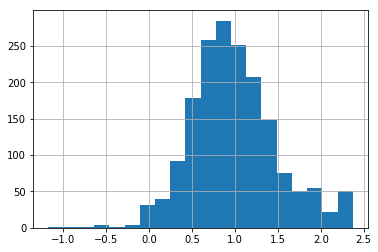

In [177]:
bm_sent['anomaly'].hist(bins = 20)

In [184]:
sent_map = folium.Map(location=cs_coordinates, zoom_start=11)

for i in bm_sent.query('latitude == latitude').head(3500).iterrows():
    lat = i[1]['latitude']
    lon = i[1]['longitude']
    if i[1]['anomaly'] < 0.75:
        plot_point(lat, lon, sent_map, fill_col = "#FF0000")
    elif i[1]['anomaly'] < 1.0:
        plot_point(lat, lon, sent_map, fill_col = "#FF2222")
    elif i[1]['anomaly'] < 1.25:
        plot_point(lat, lon, sent_map, fill_col = "#2277FF")
    else:
        plot_point(lat, lon, sent_map, fill_col = "#0000FF")
        


display(sent_map)